In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

plt.style.use('fivethirtyeight')

In [3]:
input_file_path = '..\\data\\raw_data\\CustomerChurn.csv'
df = pd.read_csv(input_file_path)

### Data PreProcessing

In [4]:
def col_common_values(df):
    cols = df.columns
    cols_common_values = [df[c].value_counts().index[:4].tolist() 
                            for c in df.columns]
                             
    ser = pd.Series(cols_common_values,index=cols)
    return ser
    
def col_properties(df):

    return pd.DataFrame( 
        {
            'type':df.dtypes,
            'NumofUnique':df.nunique(),
            'NumOfNulls':df.isnull().sum(),
            'CommonValues': col_common_values(df)
        }
    ).reset_index()


In [6]:
df = (df.assign(TotalCharges = df['TotalCharges'].replace(" ",None).astype('float64'))
        .assign(isGenderMale = df['gender'].replace({'Male':1,'Female':0}).astype('boolean'))
        .drop('gender',axis=1)
        .assign(isSeniorCitizen = df['SeniorCitizen'].astype('boolean'))
        .drop('SeniorCitizen',axis=1)
        .assign(hasPartner = df['Partner'].replace({'Yes':1,'No':0}).astype('boolean'))
        .drop('Partner',axis=1)

        .assign(hasDependents = df['Dependents'].replace({'Yes':1,'No':0}).astype('boolean'))
        .drop('Dependents',axis=1)
        .assign(hasPhoneService = df['PhoneService'].replace({'Yes':1,'No':0}).astype('boolean'))
        .drop('PhoneService',axis=1)
        .assign(hasPaperlessBilling = df['PaperlessBilling'].replace({'Yes':1,'No':0}).astype('boolean'))
        .drop('PaperlessBilling',axis=1)
        .assign(isChurned = df['Churn'].replace({'Yes':1,'No':0}).astype('boolean'))
        .drop('Churn',axis=1)

)

In [7]:
col_properties(df).query('NumofUnique ==3 ')

,index,type,NumofUnique,NumOfNulls,CommonValues
2,MultipleLines,object,3,0,"[No, Yes, No phone service]"
3,InternetService,object,3,0,"[Fiber optic, DSL, No]"
4,OnlineSecurity,object,3,0,"[No, Yes, No internet service]"
5,OnlineBackup,object,3,0,"[No, Yes, No internet service]"
6,DeviceProtection,object,3,0,"[No, Yes, No internet service]"
7,TechSupport,object,3,0,"[No, Yes, No internet service]"
8,StreamingTV,object,3,0,"[No, Yes, No internet service]"
9,StreamingMovies,object,3,0,"[No, Yes, No internet service]"
10,Contract,object,3,0,"[Month-to-month, Two year, One year]"


<AxesSubplot:xlabel='isChurned'>

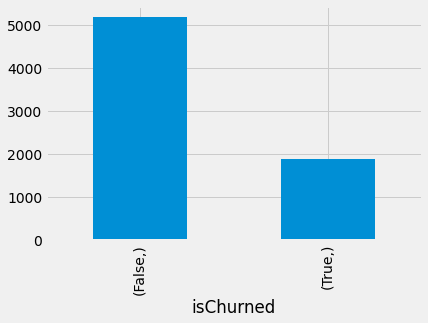

In [8]:
df[['isChurned']].value_counts().plot(kind='bar')

In [9]:
x_numeric = ['TotalCharges','MonthlyCharges','tenure','isChurned']
df[x_numeric].corr()

,TotalCharges,MonthlyCharges,tenure,isChurned
TotalCharges,1.000000,0.649178,0.822745,-0.199700
MonthlyCharges,0.649178,1.000000,0.247900,0.193356
tenure,0.822745,0.247900,1.000000,-0.352229
isChurned,-0.199700,0.193356,-0.352229,1.000000


In [11]:
col_properties(df[df['InternetService']=="No"])#.query('NumofUnique ==3 ')

,index,type,NumofUnique,NumOfNulls,CommonValues
0,customerID,object,1526,0,"[7469-LKBCI, 6112-KTHFQ, 0883-EIBTI, 4530-NDRKU]"
1,tenure,int64,73,0,"[1, 72, 2, 71]"
2,MultipleLines,object,2,0,"[No, Yes]"
3,InternetService,object,1,0,[No]
4,OnlineSecurity,object,1,0,[No internet service]
5,OnlineBackup,object,1,0,[No internet service]
6,DeviceProtection,object,1,0,[No internet service]
7,TechSupport,object,1,0,[No internet service]
8,StreamingTV,object,1,0,[No internet service]
9,StreamingMovies,object,1,0,[No internet service]


### Data Exploration

In [12]:
type(df.corr().round(2).style.background_gradient(cmap='coolwarm'))

pandas.io.formats.style.Styler

In [13]:
df.corr().round(2).style.background_gradient(cmap='coolwarm')

,tenure,MonthlyCharges,TotalCharges,isGenderMale,isSeniorCitizen,hasPartner,hasDependents,hasPhoneService,hasPaperlessBilling,isChurned
tenure,1.000000,0.250000,0.820000,0.010000,0.020000,0.380000,0.160000,0.010000,0.010000,-0.350000
MonthlyCharges,0.250000,1.000000,0.650000,-0.010000,0.220000,0.100000,-0.110000,0.250000,0.350000,0.190000
TotalCharges,0.820000,0.650000,1.000000,-0.000000,0.100000,0.320000,0.070000,0.110000,0.160000,-0.200000
isGenderMale,0.010000,-0.010000,-0.000000,1.000000,-0.000000,-0.000000,0.010000,-0.010000,-0.010000,-0.010000
isSeniorCitizen,0.020000,0.220000,0.100000,-0.000000,1.000000,0.020000,-0.210000,0.010000,0.160000,0.150000
hasPartner,0.380000,0.100000,0.320000,-0.000000,0.020000,1.000000,0.450000,0.020000,-0.010000,-0.150000
hasDependents,0.160000,-0.110000,0.070000,0.010000,-0.210000,0.450000,1.000000,-0.000000,-0.110000,-0.160000
hasPhoneService,0.010000,0.250000,0.110000,-0.010000,0.010000,0.020000,-0.000000,1.000000,0.020000,0.010000
hasPaperlessBilling,0.010000,0.350000,0.160000,-0.010000,0.160000,-0.010000,-0.110000,0.020000,1.000000,0.190000
isChurned,-0.350000,0.190000,-0.200000,-0.010000,0.150000,-0.150000,-0.160000,0.010000,0.190000,1.000000


[Text(0.5, 0, 'tenure'),
 Text(1.5, 0, 'MonthlyCharges'),
 Text(2.5, 0, 'TotalCharges'),
 Text(3.5, 0, 'isGenderMale'),
 Text(4.5, 0, 'isSeniorCitizen'),
 Text(5.5, 0, 'hasPartner'),
 Text(6.5, 0, 'hasDependents'),
 Text(7.5, 0, 'hasPhoneService'),
 Text(8.5, 0, 'hasPaperlessBilling'),
 Text(9.5, 0, 'isChurned')]

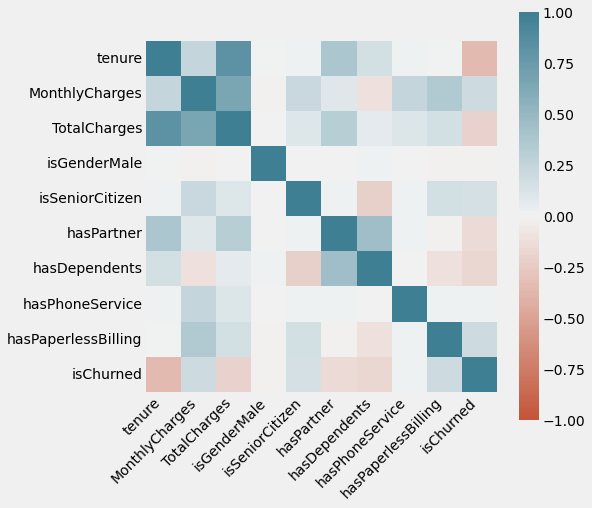

In [14]:
fig,ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

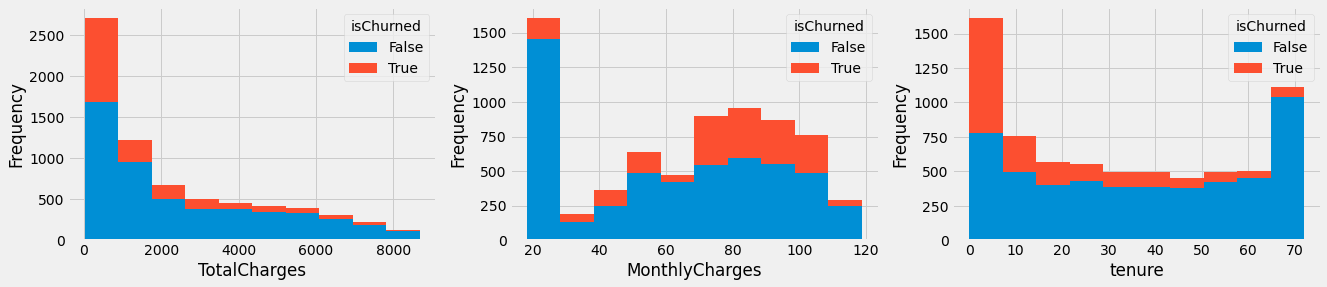

In [15]:
cols = ['TotalCharges','MonthlyCharges','tenure'] 
fig,ax = plt.subplots(1,len(cols),figsize=(20,4))

for i,col in enumerate(cols):
    df.pivot(columns='isChurned')[col].plot(kind='hist', stacked=True,ax=ax[i],xlabel=col)
    ax[i].set_xlabel(col)
    
    

* TotalCharges has high correlation with monthly charges and tenure. Will ignore the column from modelling

In [16]:
import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['red', 'green'])

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

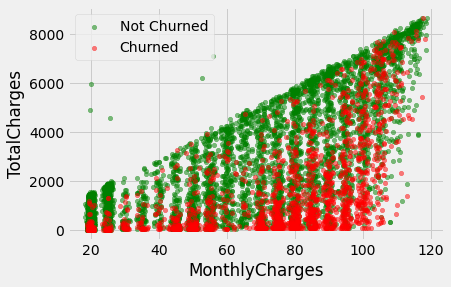

In [17]:
ax = df[df['isChurned']==0][['TotalCharges','MonthlyCharges','tenure','isChurned']].plot(kind='scatter',x='MonthlyCharges',y='TotalCharges'
,label='Not Churned',c='g',alpha=0.5)
df[df['isChurned']==1][['TotalCharges','MonthlyCharges','tenure','isChurned']].plot(kind='scatter',x='MonthlyCharges',y='TotalCharges'
, label='Churned'
,ax=ax
,c='r',alpha=0.5)

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

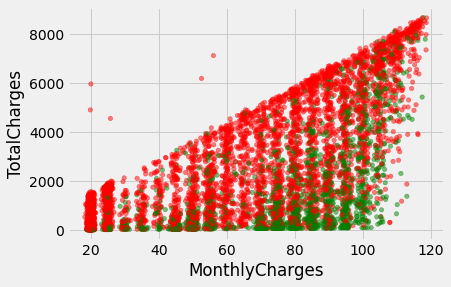

In [18]:
df[['TotalCharges','MonthlyCharges','tenure','isChurned']].plot(kind='scatter',x='MonthlyCharges',y='TotalCharges'
,c='isChurned',cmap=cmap,alpha=0.5)

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

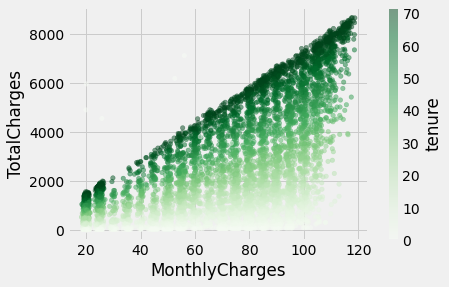

In [19]:
df[['TotalCharges','MonthlyCharges','tenure','isChurned']].plot(kind='scatter',x='MonthlyCharges',y='TotalCharges'
,c='tenure',cmap='Greens',alpha=0.5)

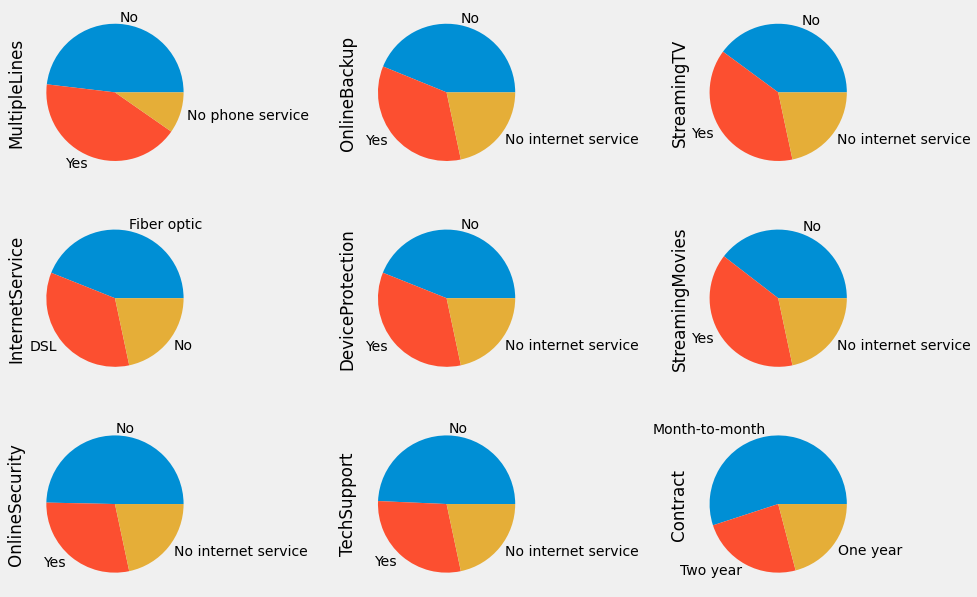

In [20]:
cols = ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract'] 
fig,ax = plt.subplots(3,3,figsize=(15,10))

for i,col in enumerate(cols):
    if i < 3:
        df[col].value_counts().plot(kind='pie',ax = ax[i,0])
    elif i < 6:
        df[col].value_counts().plot(kind='pie',ax = ax[i-3,1])
    elif i < 9:
        df[col].value_counts().plot(kind='pie',ax = ax[i-6,2])

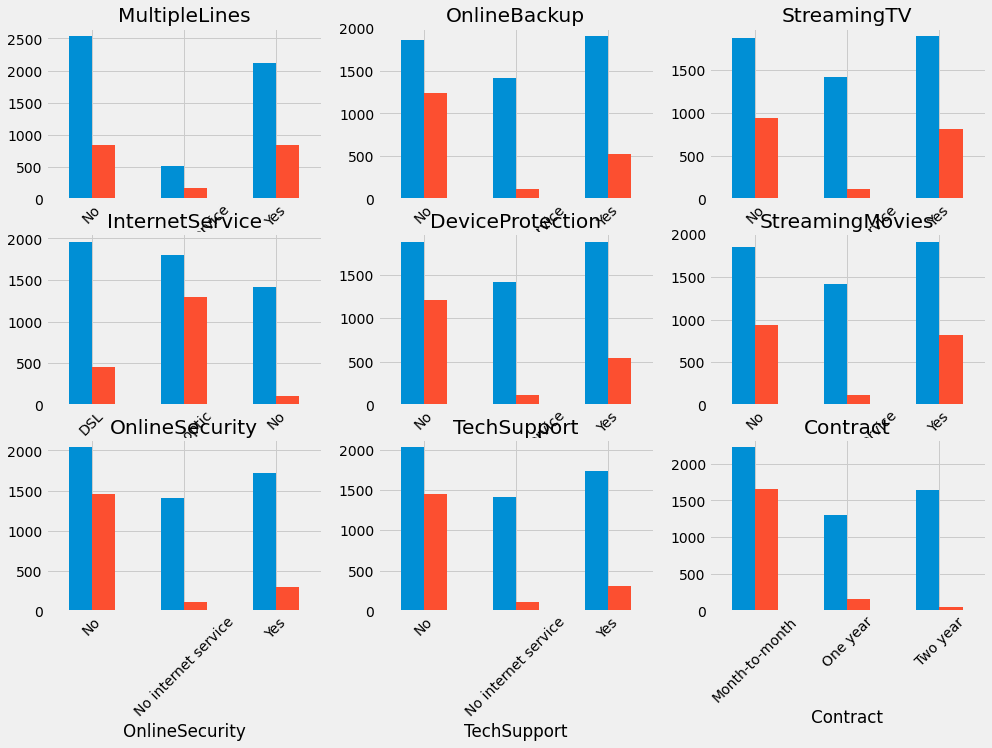

In [21]:
cols = ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract'] 
fig,ax = plt.subplots(3,3,figsize=(15,10))

for i,col in enumerate(cols):
    if i < 3:
        df.groupby('isChurned')[col].value_counts().unstack(0).plot(kind='bar',ax = ax[i,0],rot=45)
        ax[i,0].set_title(col)
        ax[i,0].get_legend().remove()

    elif i < 6:
        df.groupby('isChurned')[col].value_counts().unstack(0).plot(kind='bar',ax = ax[i-3,1],rot=45)
        ax[i-3,1].set_title(col)
        ax[i-3,1].get_legend().remove()
    elif i < 9:
        df.groupby('isChurned')[col].value_counts().unstack(0).plot(kind='bar',ax = ax[i-6,2],rot=45)
        ax[i-6,2].set_title(col)
        ax[i-6,2].get_legend().remove()

### SkLearn Preprocessing

In [22]:
col_properties(df)

,index,type,NumofUnique,NumOfNulls,CommonValues
0,customerID,object,7043,0,"[7590-VHVEG, 3791-LGQCY, 6008-NAIXK, 5956-YHHRX]"
1,tenure,int64,73,0,"[1, 72, 2, 3]"
2,MultipleLines,object,3,0,"[No, Yes, No phone service]"
3,InternetService,object,3,0,"[Fiber optic, DSL, No]"
4,OnlineSecurity,object,3,0,"[No, Yes, No internet service]"
5,OnlineBackup,object,3,0,"[No, Yes, No internet service]"
6,DeviceProtection,object,3,0,"[No, Yes, No internet service]"
7,TechSupport,object,3,0,"[No, Yes, No internet service]"
8,StreamingTV,object,3,0,"[No, Yes, No internet service]"
9,StreamingMovies,object,3,0,"[No, Yes, No internet service]"


In [23]:
df.columns

Index(['customerID', 'tenure', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'isGenderMale', 'isSeniorCitizen',
       'hasPartner', 'hasDependents', 'hasPhoneService', 'hasPaperlessBilling',
       'isChurned'],
      dtype='object')

In [24]:
x_cols = ['tenure', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'isGenderMale', 'isSeniorCitizen',
       'hasPartner', 'hasDependents', 'hasPhoneService', 'hasPaperlessBilling']
y_col = ['isChurned']
x_numeric = ['tenure','MonthlyCharges','TotalCharges']
x_categorical = [c for c in x_cols if c not in x_numeric]

x,y = df[x_cols],df[y_col]
y = y.astype('int64')
y = np.ravel(y)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [27]:
numeric_pipeline = Pipeline(steps=[
    ('scale', StandardScaler())
    ])
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False,drop='first'))
])
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, x_numeric),
    ('category', categorical_pipeline, x_categorical)
])
model_pipeline = RandomForestClassifier(n_estimators=500,max_features='auto',max_depth=12, criterion='gini')



### Model Devlopment

In [28]:
model = Pipeline(steps=[
                        ('preprocess', preprocess_pipeline),
                        ('model', model_pipeline)])

In [29]:
model.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('category',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MultipleLines',
                                                   'InternetService',
                    

In [30]:
y_pred = model.predict(x_test)

In [31]:
accuracy_score(y_test, y_pred)

0.7998106956933271

In [32]:
roc_auc_score(y_test, y_pred)

0.710340450688552

In [33]:
print(confusion_matrix(y_test, y_pred))

[[1401  159]
 [ 264  289]]


<AxesSubplot:>

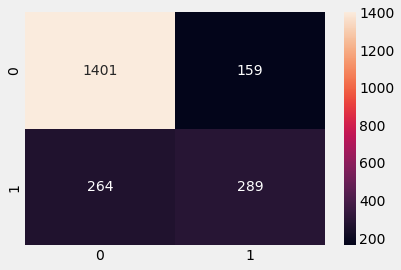

In [35]:
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='g')

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1560
           1       0.65      0.52      0.58       553

    accuracy                           0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



In [37]:
cross_val_score(model, x_train, y_train, cv=3, scoring="accuracy")

array([0.79987835, 0.7948874 , 0.79732197])

In [38]:
params = { 
    'model__n_estimators': [200, 500],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth' : [4,5,6,7,8],
    'model__criterion' :['gini', 'entropy']
}

In [39]:
cvmodel = GridSearchCV(estimator=model, param_grid=params, cv= 5)
cvmodel.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('number',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler())]),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('category',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                               

In [40]:
cvmodel.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 8,
 'model__max_features': 'auto',
 'model__n_estimators': 500}

In [41]:
print(cvmodel.best_estimator_)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('category',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MultipleLines',
                                                   'InternetService',
                    